In [1]:
import random, torch

In [2]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
from gan import datasets, networks, training, utils

In [4]:
mnist = datasets.fetch_mnist()

In [5]:
latent_dim = 100
feature_map_size = 64

gen_net = networks.Generator(latent_dim = latent_dim, feature_map_size = feature_map_size).to(device)
disc_net = networks.Discriminator().to(device)

In [6]:
dataloader = torch.utils.data.DataLoader(mnist.data, batch_size=128,
                                         shuffle=True, drop_last = True, num_workers=2)

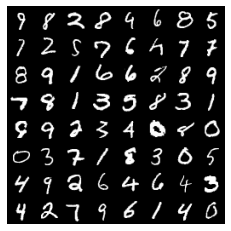

In [9]:
utils.plot_img(next(iter(dataloader))[:64], file_name = "real_mnist.jpg")

Starting Training Loop...
[0/20][0/546] Loss_D: 1.492 Loss_G 0.838 D(x): 0.442
[0/20][50/546] Loss_D: 1.297 Loss_G 1.099 D(x): 0.616
[0/20][100/546] Loss_D: 1.274 Loss_G 1.243 D(x): 0.499
[0/20][150/546] Loss_D: 0.996 Loss_G 1.541 D(x): 0.58
[0/20][200/546] Loss_D: 0.947 Loss_G 1.34 D(x): 0.574
[0/20][250/546] Loss_D: 1.053 Loss_G 1.102 D(x): 0.615
[0/20][300/546] Loss_D: 1.242 Loss_G 1.195 D(x): 0.574
[0/20][350/546] Loss_D: 1.264 Loss_G 1.087 D(x): 0.543
[0/20][400/546] Loss_D: 1.233 Loss_G 0.874 D(x): 0.553
[0/20][450/546] Loss_D: 1.235 Loss_G 0.804 D(x): 0.517
[0/20][500/546] Loss_D: 1.183 Loss_G 1.013 D(x): 0.626
[1/20][0/546] Loss_D: 1.166 Loss_G 1.242 D(x): 0.637
[1/20][50/546] Loss_D: 1.25 Loss_G 0.658 D(x): 0.423
[1/20][100/546] Loss_D: 1.166 Loss_G 1.028 D(x): 0.576
[1/20][150/546] Loss_D: 1.132 Loss_G 0.919 D(x): 0.525
[1/20][200/546] Loss_D: 1.232 Loss_G 0.556 D(x): 0.458
[1/20][250/546] Loss_D: 1.219 Loss_G 0.929 D(x): 0.554
[1/20][300/546] Loss_D: 1.215 Loss_G 0.807 D(x):

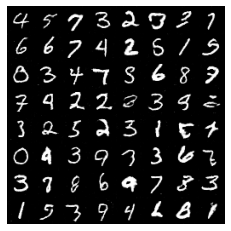

In [10]:
training.train(gen_net, disc_net, dataloader, device)